# First Installing all the requirements

In [1]:
pip install -r requirements.txt

  Using cached appnope-0.1.3-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached asttokens-2.1.0-py2.py3-none-any.whl.metadata (4.8 kB)
  Using cached backcall-0.2.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached certifi-2022.9.24-py3-none-any.whl.metadata (2.9 kB)
  Using cached charset_normalizer-2.1.1-py3-none-any.whl.metadata (11 kB)
  Using cached comm-0.1.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached debugpy-1.6.3-py2.py3-none-any.whl.metadata (1.1 kB)
  Using cached executing-1.2.0-py2.py3-none-any.whl.metadata (8.9 kB)
  Using cached filelock-3.8.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached huggingface_hub-0.11.1-py3-none-any.whl.metadata (7.5 kB)
  Using cached ipykernel-6.18.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached ipython-8.7.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached jedi-0.18.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached jupyter_client-7.4.7-py3-none-any.whl.metadata (8.5 kB)
  Using cached jupyter_core-5.1.0-py3-none-any.

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement torch==1.13.0 (from versions: 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2)
ERROR: No matching distribution found for torch==1.13.0


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install accelerate -U

   ---------------------------------------- 0.0/297.4 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/297.4 kB 1.4 MB/s eta 0:00:01
   ------------ --------------------------- 92.2/297.4 kB 1.1 MB/s eta 0:00:01
   ---------------------------------- ----- 256.0/297.4 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 297.4/297.4 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.


## Dataset extract and splitting and converting it to CSV

In [1]:
!python data_prepare.py -t 90

Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4
Length of file_data: 4


In [7]:
%env TF_ENABLE_ONEDNN_OPTS=0

env: TF_ENABLE_ONEDNN_OPTS=0


## Now training different models and comparing which one is better

## 1.Training (DistilBert)

In [1]:
#!/usr/bin/env python3
import pandas as pd
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments

def preprocess_data(data_path):
    train = pd.read_csv(data_path)
    train.drop("id", axis=1, inplace=True)
    return train

def tokenize_data(data, tokenizer):
    inputs = tokenizer(data['contents'].tolist(), padding="max_length", truncation=True)
    return inputs

class PDFDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

def train_model(model, training_args, train_dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )
    trainer.train()
    return model

def save_model_weights(model, file_path):
    torch.save(model.state_dict(), file_path)

def main():
    data_path = "./data/training.csv"
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
    )

    train = preprocess_data(data_path)
    inputs = tokenize_data(train, tokenizer)
    train_dataset = PDFDataset(inputs, train['label'].tolist())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trained_model = train_model(model, training_args, train_dataset)

    save_model_weights(trained_model, 'model_weights.pth')

if __name__ == "__main__":
    main()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\anaconda\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,0.679700
20,0.652400
30,0.620800
40,0.549500
50,0.479300
60,0.434400
70,0.388800
80,0.321200
90,0.364800
100,0.305000


## Validating the model(DistilBert)

In [2]:
#!/usr/bin/env python3
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
import pandas as pd
import numpy as np

def load_model(model_path):
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def encode_data(data, tokenizer, device):
    encoded_data = tokenizer(data, truncation=True, padding=True)
    input_ids = torch.tensor(encoded_data['input_ids']).to(device)
    attention_mask = torch.tensor(encoded_data['attention_mask']).to(device)
    return input_ids, attention_mask

def evaluate(model, test_data, tokenizer, device):
    predictions = []
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for content, label in zip(test_data['contents'], test_data['label']):
        input_ids, attention_mask = encode_data(content, tokenizer, device)
        with torch.no_grad():
            outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
        prediction = np.argmax(outputs[0].to('cpu').numpy())
        predictions.append(prediction)

        if label == 1 and prediction == 1:
            true_positive += 1
        elif label == 0 and prediction == 0:
            true_negative += 1
        elif label == 1 and prediction == 0:
            false_negative += 1
        elif label == 0 and prediction == 1:
            false_positive += 1

    return predictions, true_positive, false_positive, true_negative, false_negative

def print_evaluation(predictions, true_positive, false_positive, true_negative, false_negative):
    print(predictions)
    print("True Positive:", true_positive)
    print("True Negative:", true_negative)
    print("False Positive:", false_positive)
    print("False Negative:", false_negative)

    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    print("Accuracy:", accuracy)

    precision = true_positive / (true_positive + false_positive)
    print("Precision:", precision)

    recall = true_positive / (true_positive + false_negative)
    print("Recall:", recall)

    f1_score = 2 * (recall * precision) / (recall + precision)
    print("F1-score:", f1_score)

    specificity = true_negative / (true_negative + false_positive)
    print("Specificity:", specificity)

def main():
    model_path = "./results/model_weights.pth"
    test_data_path = "./data/testing.csv"

    model = load_model(model_path)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

    test_data = pd.read_csv(test_data_path)
    test_data.drop("id", axis=1, inplace=True)

    predictions, true_positive, false_positive, true_negative, false_negative = evaluate(model, test_data, tokenizer, device)

    print_evaluation(predictions, true_positive, false_positive, true_negative, false_negative)

if __name__ == "__main__":
    main()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True Positive: 96
True Negative: 43
False Positive: 7
False Negative: 4
Accuracy: 0.9266666666666666
Precision: 0.9320388349514563
Recall: 0.96
F1-score: 0.9458128078817734
Specificity: 0.86


## 2. Training (Bert)

In [1]:
#!/usr/bin/env python3
import pandas as pd
import torch
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments

def preprocess_data(data_path):
    train = pd.read_csv(data_path)
    train.drop("id", axis=1, inplace=True)
    return train

def tokenize_data(data, tokenizer):
    inputs = tokenizer(data['contents'].tolist(), padding="max_length", truncation=True)
    return inputs

class PDFDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

def train_model(model, training_args, train_dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )
    trainer.train()
    return model

def save_model_weights(model, file_path):
    torch.save(model.state_dict(), file_path)

def main():
    data_path = "./data/training.csv"
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
    )

    train = preprocess_data(data_path)
    inputs = tokenize_data(train, tokenizer)
    train_dataset = PDFDataset(inputs, train['label'].tolist())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trained_model = train_model(model, training_args, train_dataset)

    save_model_weights(trained_model, 'model_weights.pth')

if __name__ == "__main__":
    main()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\anaconda\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,0.702800
20,0.641500
30,0.588500
40,0.471400
50,0.414600
60,0.394900
70,0.344600
80,0.285400
90,0.312100
100,0.239700


## Validating (Bert)

In [2]:
#!/usr/bin/env python3
import torch
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizerFast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def load_model(model_path):
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def encode_data(data, tokenizer, device):
    encoded_data = tokenizer(data, truncation=True, padding=True, return_tensors='pt')
    input_ids = encoded_data['input_ids'].to(device)
    attention_mask = encoded_data['attention_mask'].to(device)
    return input_ids, attention_mask

def evaluate(model, test_data, tokenizer, device):
    predictions = []
    true_labels = []

    for content, label in zip(test_data['contents'], test_data['label']):
        input_ids, attention_mask = encode_data(content, tokenizer, device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).cpu().numpy()[0]
        predictions.append(prediction)
        true_labels.append(label)

    return predictions, true_labels

def print_evaluation(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    confusion = confusion_matrix(true_labels, predictions)

    print("Confusion Matrix:")
    print(confusion)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

def main():
    model_path = "./results/model_weights.pth"
    test_data_path = "./data/testing.csv"

    model = load_model(model_path)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

    test_data = pd.read_csv(test_data_path)
    test_data.drop("id", axis=1, inplace=True)

    predictions, true_labels = evaluate(model, test_data, tokenizer, device)

    print_evaluation(predictions, true_labels)

if __name__ == "__main__":
    main()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[48  2]
 [ 5 95]]
Accuracy: 0.9533333333333334
Precision: 0.979381443298969
Recall: 0.95
F1 Score: 0.9644670050761421


## 3. Training (RoBERTa)

In [1]:
#!/usr/bin/env python3
import pandas as pd
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast, Trainer, TrainingArguments

def preprocess_data(data_path):
    train = pd.read_csv(data_path)
    train.drop("id", axis=1, inplace=True)
    return train

def tokenize_data(data, tokenizer):
    inputs = tokenizer(data['contents'].tolist(), padding="max_length", truncation=True)
    return inputs

class PDFDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

def train_model(model, training_args, train_dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )
    trainer.train()
    return model

def save_model_weights(model, file_path):
    torch.save(model.state_dict(), file_path)

def main():
    data_path = "./data/training.csv"
    tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
    model = RobertaForSequenceClassification.from_pretrained("roberta-base")
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
    )

    train = preprocess_data(data_path) 
    inputs = tokenize_data(train, tokenizer)
    train_dataset = PDFDataset(inputs, train['label'].tolist())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trained_model = train_model(model, training_args, train_dataset)

    save_model_weights(trained_model, 'model_weights.pth')

if __name__ == "__main__":
    main()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\anaconda\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,0.700000
20,0.684800
30,0.651200
40,0.577200
50,0.552900
60,0.463200
70,0.382300
80,0.331900
90,0.252400
100,0.216400


## Validating (RoBERTa)

In [2]:
#!/usr/bin/env python3
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
import pandas as pd
import numpy as np

def load_model(model_path):
    model = RobertaForSequenceClassification.from_pretrained("roberta-base")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def encode_data(data, tokenizer, device):
    encoded_data = tokenizer(data, truncation=True, padding=True)
    input_ids = torch.tensor(encoded_data['input_ids']).to(device)
    attention_mask = torch.tensor(encoded_data['attention_mask']).to(device)
    return input_ids, attention_mask

def evaluate(model, test_data, tokenizer, device):
    predictions = []
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for content, label in zip(test_data['contents'], test_data['label']):
        input_ids, attention_mask = encode_data(content, tokenizer, device)
        with torch.no_grad():
            outputs = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
        prediction = np.argmax(outputs.logits.to('cpu').numpy())
        predictions.append(prediction)

        if label == 1 and prediction == 1:
            true_positive += 1
        elif label == 0 and prediction == 0:
            true_negative += 1
        elif label == 1 and prediction == 0:
            false_negative += 1
        elif label == 0 and prediction == 1:
            false_positive += 1

    return predictions, true_positive, false_positive, true_negative, false_negative

def print_evaluation(predictions, true_positive, false_positive, true_negative, false_negative):
    print(predictions)
    print("True Positive:", true_positive)
    print("True Negative:", true_negative)
    print("False Positive:", false_positive)
    print("False Negative:", false_negative)

    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    print("Accuracy:", accuracy)

    precision = true_positive / (true_positive + false_positive)
    print("Precision:", precision)

    recall = true_positive / (true_positive + false_negative)
    print("Recall:", recall)

    f1_score = 2 * (recall * precision) / (recall + precision)
    print("F1-score:", f1_score)

    specificity = true_negative / (true_negative + false_positive)
    print("Specificity:", specificity)

def main():
    model_path = "./results/model_weights.pth"
    test_data_path = "./data/testing.csv"

    model = load_model(model_path)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

    test_data = pd.read_csv(test_data_path)
    test_data.drop("id", axis=1, inplace=True)

    predictions, true_positive, false_positive, true_negative, false_negative = evaluate(model, test_data, tokenizer, device)

    print_evaluation(predictions, true_positive, false_positive, true_negative, false_negative)

if __name__ == "__main__":
    main()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
True Positive: 93
True Negative: 48
False Positive: 2
False Negative: 7
Accuracy: 0.94
Precision: 0.9789473684210527
Recall: 0.93
F1-score: 0.9538461538461539
Specificity: 0.96


## 4. Training (ELECTRA)

In [3]:
#!/usr/bin/env python3
import pandas as pd
import torch
from transformers import ElectraForSequenceClassification, ElectraTokenizerFast, Trainer, TrainingArguments

def preprocess_data(data_path):
    train = pd.read_csv(data_path)
    train.drop("id", axis=1, inplace=True)
    return train

def tokenize_data(data, tokenizer):
    inputs = tokenizer(data['contents'].tolist(), padding="max_length", truncation=True)
    return inputs

class PDFDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

def train_model(model, training_args, train_dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )
    trainer.train()
    return model

def save_model_weights(model, file_path):
    torch.save(model.state_dict(), file_path)

def main():
    data_path = "./data/training.csv"
    tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-base-discriminator")
    model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator")
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
    )

    train = preprocess_data(data_path)
    inputs = tokenize_data(train, tokenizer)
    train_dataset = PDFDataset(inputs, train['label'].tolist())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trained_model = train_model(model, training_args, train_dataset)

    save_model_weights(trained_model, 'model_weights.pth')

if __name__ == "__main__":
    main()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\anaconda\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,0.692700
20,0.652100
30,0.613100
40,0.547700
50,0.511700
60,0.486100
70,0.424600
80,0.368400
90,0.367600
100,0.290400


## Validating (ELECTRA)

In [4]:
#!/usr/bin/env python3
import torch
from transformers import ElectraForSequenceClassification, ElectraTokenizerFast
import pandas as pd
import numpy as np

def load_model(model_path):
    model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def encode_data(data, tokenizer, device):
    encoded_data = tokenizer(data, truncation=True, padding=True)
    input_ids = torch.tensor(encoded_data['input_ids']).to(device)
    attention_mask = torch.tensor(encoded_data['attention_mask']).to(device)
    return input_ids, attention_mask

def evaluate(model, test_data, tokenizer, device):
    predictions = []
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for content, label in zip(test_data['contents'], test_data['label']):
        input_ids, attention_mask = encode_data(content, tokenizer, device)
        with torch.no_grad():
            outputs = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
        prediction = np.argmax(outputs.logits.to('cpu').numpy())
        predictions.append(prediction)

        if label == 1 and prediction == 1:
            true_positive += 1
        elif label == 0 and prediction == 0:
            true_negative += 1
        elif label == 1 and prediction == 0:
            false_negative += 1
        elif label == 0 and prediction == 1:
            false_positive += 1

    return predictions, true_positive, false_positive, true_negative, false_negative

def print_evaluation(predictions, true_positive, false_positive, true_negative, false_negative):
    print(predictions)
    print("True Positive:", true_positive)
    print("True Negative:", true_negative)
    print("False Positive:", false_positive)
    print("False Negative:", false_negative)

    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    print("Accuracy:", accuracy)

    precision = true_positive / (true_positive + false_positive)
    print("Precision:", precision)

    recall = true_positive / (true_positive + false_negative)
    print("Recall:", recall)

    f1_score = 2 * (recall * precision) / (recall + precision)
    print("F1-score:", f1_score)

    specificity = true_negative / (true_negative + false_positive)
    print("Specificity:", specificity)

def main():
    model_path = "./results/model_weights.pth"
    test_data_path = "./data/testing.csv"

    model = load_model(model_path)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-base-discriminator")

    test_data = pd.read_csv(test_data_path)
    test_data.drop("id", axis=1, inplace=True)

    predictions, true_positive, false_positive, true_negative, false_negative = evaluate(model, test_data, tokenizer, device)

    print_evaluation(predictions, true_positive, false_positive, true_negative, false_negative)

if __name__ == "__main__":
    main()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True Positive: 96
True Negative: 45
False Positive: 5
False Negative: 4
Accuracy: 0.94
Precision: 0.9504950495049505
Recall: 0.96
F1-score: 0.9552238805970149
Specificity: 0.9


## 5. Training (ALBERT)

In [1]:
#!/usr/bin/env python3
import pandas as pd
import torch
from transformers import AlbertForSequenceClassification, AlbertTokenizerFast, Trainer, TrainingArguments

def preprocess_data(data_path):
    train = pd.read_csv(data_path)
    train.drop("id", axis=1, inplace=True)
    return train

def tokenize_data(data, tokenizer):
    inputs = tokenizer(data['contents'].tolist(), padding="max_length", truncation=True)
    return inputs

class PDFDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

def train_model(model, training_args, train_dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )
    trainer.train()
    return model

def save_model_weights(model, file_path):
    torch.save(model.state_dict(), file_path)

def main():
    data_path = "./data/training.csv"
    tokenizer = AlbertTokenizerFast.from_pretrained("albert-base-v2")
    model = AlbertForSequenceClassification.from_pretrained("albert-base-v2")
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
    )

    train = preprocess_data(data_path)
    inputs = tokenize_data(train, tokenizer)
    train_dataset = PDFDataset(inputs, train['label'].tolist())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trained_model = train_model(model, training_args, train_dataset)

    save_model_weights(trained_model, 'model_weights.pth')

if __name__ == "__main__":
    main()


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\anaconda\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,0.703400
20,0.585200
30,0.503200
40,0.395600
50,0.331700
60,0.281900
70,0.287100
80,0.199400
90,0.199500
100,0.115100


## Validating (ALBERT)

In [1]:
#!/usr/bin/env python3
import torch
from transformers import AlbertForSequenceClassification, AlbertTokenizerFast
import pandas as pd
import numpy as np

def load_model(model_path):
    model = AlbertForSequenceClassification.from_pretrained("albert-base-v2")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def encode_data(data, tokenizer, device):
    encoded_data = tokenizer(data, truncation=True, padding=True)
    input_ids = torch.tensor(encoded_data['input_ids']).to(device)
    attention_mask = torch.tensor(encoded_data['attention_mask']).to(device)
    return input_ids, attention_mask

def evaluate(model, test_data, tokenizer, device):
    predictions = []
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for content, label in zip(test_data['contents'], test_data['label']):
        input_ids, attention_mask = encode_data(content, tokenizer, device)
        with torch.no_grad():
            outputs = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
        prediction = np.argmax(outputs.logits.to('cpu').numpy())
        predictions.append(prediction)

        if label == 1 and prediction == 1:
            true_positive += 1
        elif label == 0 and prediction == 0:
            true_negative += 1
        elif label == 1 and prediction == 0:
            false_negative += 1
        elif label == 0 and prediction == 1:
            false_positive += 1

    return predictions, true_positive, false_positive, true_negative, false_negative

def print_evaluation(predictions, true_positive, false_positive, true_negative, false_negative):
    print(predictions)
    print("True Positive:", true_positive)
    print("True Negative:", true_negative)
    print("False Positive:", false_positive)
    print("False Negative:", false_negative)

    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    print("Accuracy:", accuracy)

    precision = true_positive / (true_positive + false_positive)
    print("Precision:", precision)

    recall = true_positive / (true_positive + false_negative)
    print("Recall:", recall)

    f1_score = 2 * (recall * precision) / (recall + precision)
    print("F1-score:", f1_score)

    specificity = true_negative / (true_negative + false_positive)
    print("Specificity:", specificity)

def main():
    model_path = "./results/model_weights.pth"
    test_data_path = "./data/testing.csv"

    model = load_model(model_path)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    tokenizer = AlbertTokenizerFast.from_pretrained("albert-base-v2")

    test_data = pd.read_csv(test_data_path)
    test_data.drop("id", axis=1, inplace=True)

    predictions, true_positive, false_positive, true_negative, false_negative = evaluate(model, test_data, tokenizer, device)

    print_evaluation(predictions, true_positive, false_positive, true_negative, false_negative)

if __name__ == "__main__":
    main()


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True Positive: 96
True Negative: 47
False Positive: 3
False Negative: 4
Accuracy: 0.9533333333333334
Precision: 0.9696969696969697
Recall: 0.96
F1-score: 0.964824120603015
Specificity: 0.94


# Comparing all the models

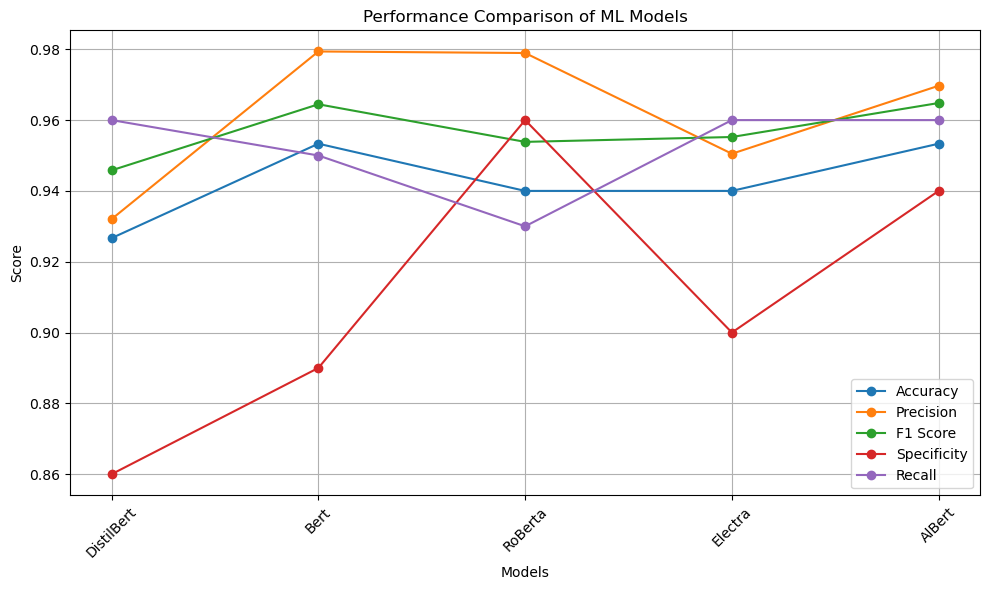

In [1]:
import matplotlib.pyplot as plt

# Define the models and their corresponding performance metrics
models = ['DistilBert', 'Bert', 'RoBerta','Electra','AlBert']
accuracy = [0.9266666666666666, 0.9533333333333334, 0.94,0.94,0.9533333333333334]
precision = [0.9320388349514563, 0.979381443298969, 0.9789473684210527,0.9504950495049505,0.9696969696969697]
f1_score = [0.9458128078817734, 0.9644670050761421, 0.9538461538461539,0.9552238805970149,0.964824120603015]
specificity = [0.86, 0.89, 0.96,0.9,0.94]
recall = [0.96, 0.95, 0.93,0.96,0.96]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(models, accuracy, marker='o', label='Accuracy')
plt.plot(models, precision, marker='o', label='Precision')
plt.plot(models, f1_score, marker='o', label='F1 Score')
plt.plot(models, specificity, marker='o', label='Specificity')
plt.plot(models, recall, marker='o', label='Recall')

plt.title('Performance Comparison of ML Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


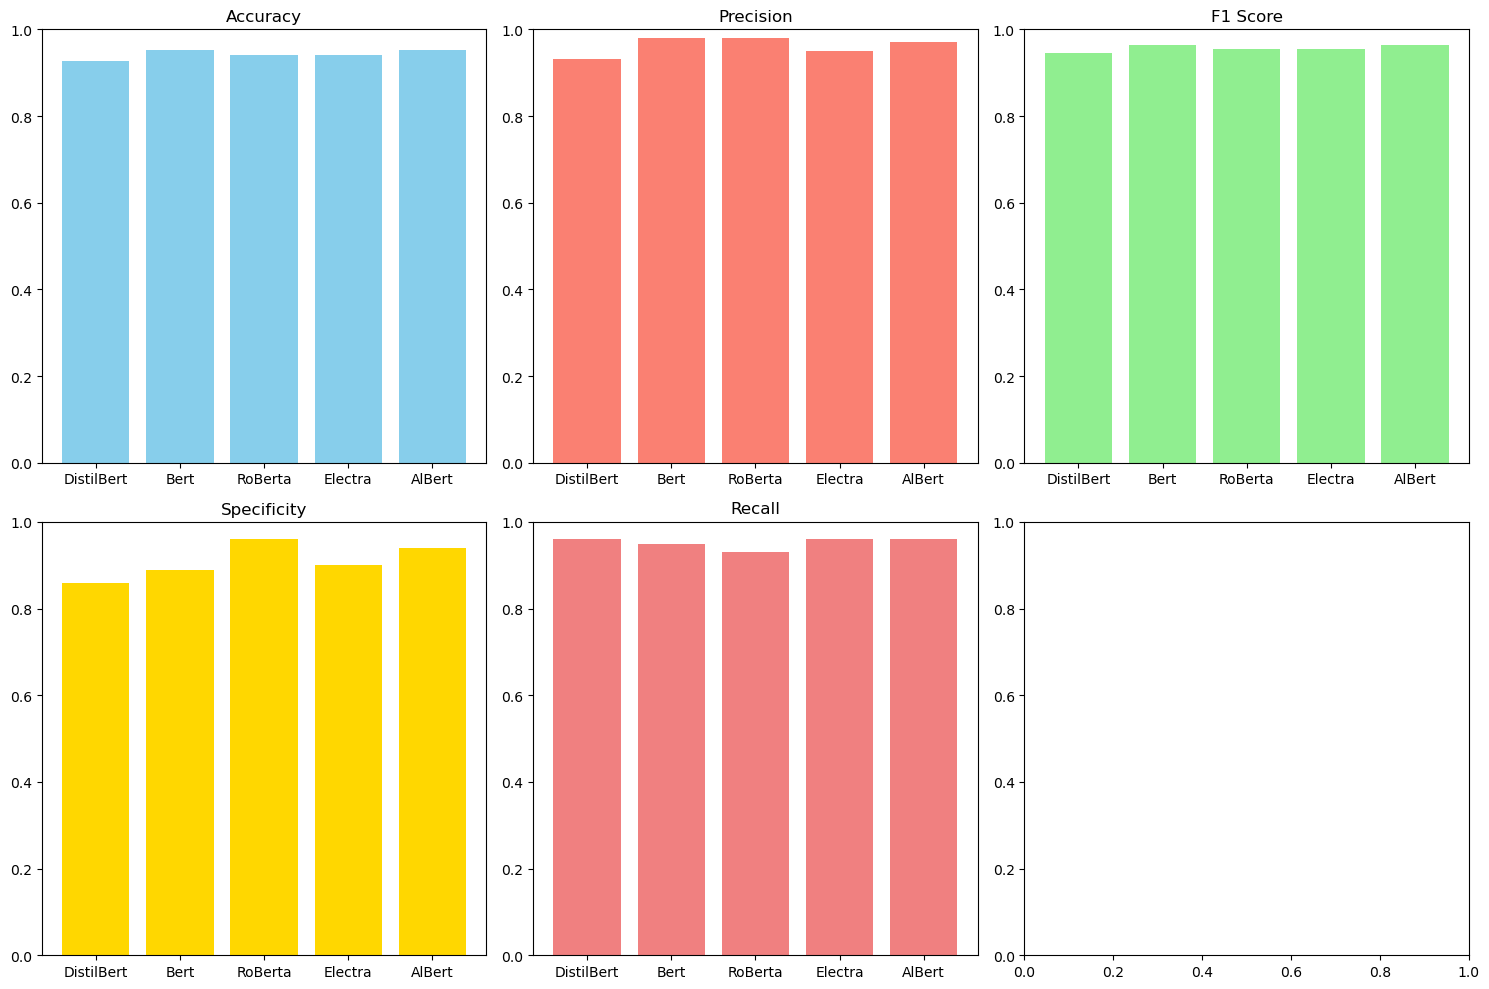

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their corresponding performance metrics
models = ['DistilBert', 'Bert', 'RoBerta','Electra','AlBert']
accuracy = [0.9266666666666666, 0.9533333333333334, 0.94,0.94,0.9533333333333334]
precision = [0.9320388349514563, 0.979381443298969, 0.9789473684210527,0.9504950495049505,0.9696969696969697]
f1_score = [0.9458128078817734, 0.9644670050761421, 0.9538461538461539,0.9552238805970149,0.964824120603015]
specificity = [0.86, 0.89, 0.96,0.9,0.94]
recall = [0.96, 0.95, 0.93,0.96,0.96]

# Create subplots for each performance metric
metrics = ['Accuracy', 'Precision', 'F1 Score', 'Specificity', 'Recall']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Plot the metric for each model
    if metric == 'Accuracy':
        ax.bar(models, accuracy, color='skyblue')
    elif metric == 'Precision':
        ax.bar(models, precision, color='salmon')
    elif metric == 'F1 Score':
        ax.bar(models, f1_score, color='lightgreen')
    elif metric == 'Specificity':
        ax.bar(models, specificity, color='gold')
    elif metric == 'Recall':
        ax.bar(models, recall, color='lightcoral')
    
    ax.set_title(metric)
    ax.set_ylim([0, 1])  # Set y-axis limit to ensure consistency

# Adjust layout and display
plt.tight_layout()
plt.show()
